# Neural Network and Math Playtime 2

## Goals
* Repeat some steps from version 1, but using PyTorch instead of TensorFlow
* Practice using custom training loops

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim



In [2]:
rng = np.random.default_rng(seed=42)

In [3]:
# Start with polynomial function

func0_par_0=1
func0_par_1=-1
func0_par_2=1
func0_par_3=-1
func0_par_4=0.25

def function0(x):
    # start with quadratic
#    return func0_par_0 + func0_par_1*x
    return func0_par_0 + func0_par_1 * x + func0_par_2*x*x + func0_par_3*x*x*x + func0_par_4*x*x*x*x

In [4]:
# prototyping some noisy functions
function0_vert_noise_sigma = 0.5


def function0_vert_noise(x):
    """
    Function 0 but with vertical noise with sigma function0_vert_noise_sigma added
    """
    value = function0(x)
    return value + rng.normal(0,function0_vert_noise_sigma)

In [5]:
function0_horiz_noise_sigma = 0.5

def function0_horiz_noise(x):
    """
    Function 0 but with horizontal noise with sigma function0_horiz_noise_sigma added
    
    """
    x += rng.normal(0,function0_vert_noise_sigma)
    return function0(x)

In [6]:
N_x_samples = 512

x_mu = 0.0
x_sig = 1.0
# sample x values 

x_values = rng.normal(x_mu,x_sig,N_x_samples)

In [7]:
print(x_values[:64])
print(type(x_values))
y_f0_values = np.array(list(map(function0,x_values)))

[ 0.30471708 -1.03998411  0.7504512   0.94056472 -1.95103519 -1.30217951
  0.1278404  -0.31624259 -0.01680116 -0.85304393  0.87939797  0.77779194
  0.0660307   1.12724121  0.46750934 -0.85929246  0.36875078 -0.9588826
  0.8784503  -0.04992591 -0.18486236 -0.68092954  1.22254134 -0.15452948
 -0.42832782 -0.35213355  0.53230919  0.36544406  0.41273261  0.430821
  2.1416476  -0.40641502 -0.51224273 -0.81377273  0.61597942  1.12897229
 -0.11394746 -0.84015648 -0.82448122  0.65059279  0.74325417  0.54315427
 -0.66550971  0.23216132  0.11668581  0.2186886   0.87142878  0.22359555
  0.67891356  0.06757907  0.2891194   0.63128823 -1.45715582 -0.31967122
 -0.47037265 -0.63887785 -0.27514225  1.49494131 -0.86583112  0.96827835
 -1.68286977 -0.33488503  0.16275307  0.58622233]
<class 'numpy.ndarray'>


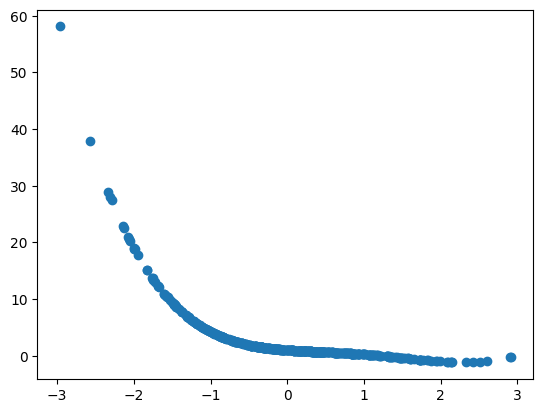

In [8]:
fig, ax = plt.subplots()
ax.plot(x_values,y_f0_values,marker='o',linestyle='')

In [9]:
y_f0_vnoise_values = np.array(list(map(function0_vert_noise,x_values)))
y_f0_hnoise_values = np.array(list(map(function0_horiz_noise,x_values)))

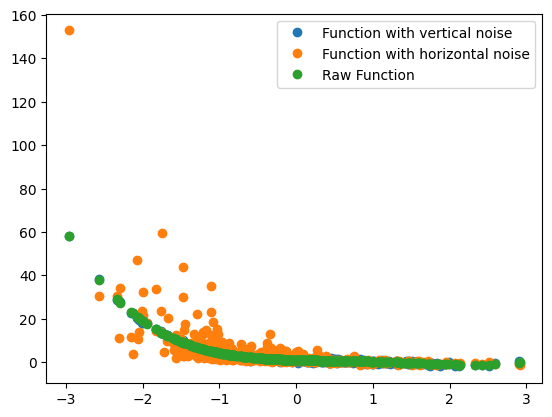

In [10]:
fig, ax = plt.subplots()
ax.plot(x_values,y_f0_vnoise_values,marker='o',linestyle='',label="Function with vertical noise")
ax.plot(x_values,y_f0_hnoise_values,marker='o',linestyle='',label="Function with horizontal noise")
ax.plot(x_values,y_f0_values,marker='o',linestyle='',label="Raw Function")

plt.legend()

# Training and Testing Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
test_size=0.15
local_X = x_values
local_y = y_f0_values
X_train, X_valid, y_train, y_valid = train_test_split(local_X, local_y, test_size=test_size, shuffle=True)

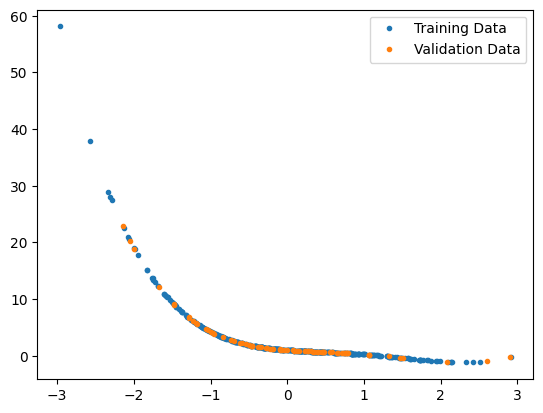

In [13]:
fig,ax = plt.subplots()
ax.plot(X_train,y_train,label="Training Data",marker='.',linestyle='')
ax.plot(X_valid,y_valid,label="Validation Data",marker='.',linestyle='')
plt.legend()

torch.Size([435])
torch.Size([435])
torch.Size([77])
torch.Size([77])
After unsqueezing to add a batch dimension
torch.Size([435, 1])
torch.Size([435, 1])
torch.Size([77, 1])
torch.Size([77, 1])


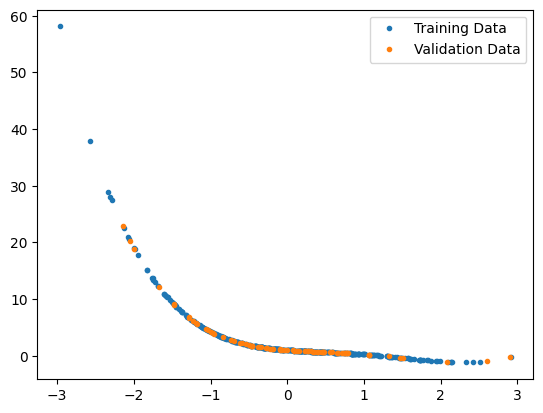

In [14]:
# Convert to pytorch format
X_train_py = torch.tensor(X_train,dtype=torch.float32)
y_train_py = torch.tensor(y_train,dtype=torch.float32)
X_valid_py = torch.tensor(X_valid,dtype=torch.float32)
y_valid_py = torch.tensor(y_valid,dtype=torch.float32)
print(X_train_py.shape)
print(y_train_py.shape)
print(X_valid_py.shape)
print(y_valid_py.shape)
print("After unsqueezing to add a batch dimension")
X_train_py = X_train_py.unsqueeze(-1)
y_train_py = y_train_py.unsqueeze(-1)
X_valid_py = X_valid_py.unsqueeze(-1)
y_valid_py = y_valid_py.unsqueeze(-1)
print(X_train_py.shape)
print(y_train_py.shape)
print(X_valid_py.shape)
print(y_valid_py.shape)
# Checking that I can plot the tensor formatted data just as easily
fig,ax = plt.subplots()
ax.plot(X_train_py[:,0],y_train_py[:,0],label="Training Data",marker='.',linestyle='')
ax.plot(X_valid_py[:,0],y_valid_py[:,0],label="Validation Data",marker='.',linestyle='')
plt.legend()

# Building a Neural Network with PyTorch

In [15]:
# Check the device information
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [16]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1,25),
            nn.ReLU(),
            nn.Linear(25,10),
            nn.ReLU(),
            nn.Linear(10,1),
        )
    def forward(self,x):
        x = self.linear_relu_stack(x)
        return x
    
    

In [17]:
torch.manual_seed(0)

In [18]:
model = MyNeuralNetwork().to(device)
print(model)

MyNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [19]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight | Size: torch.Size([25, 1]) | Values : tensor([[-0.0075],
        [ 0.5364]], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([25]) | Values : tensor([0.1058, 0.9055], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([10, 25]) | Values : tensor([[ 0.1279,  0.1988,  0.0794,  0.0270,  0.1341, -0.1178,  0.0373, -0.1551,
         -0.1386, -0.1033,  0.0905,  0.0804, -0.1185,  0.0604,  0.1098, -0.0252,
          0.0076,  0.0463,  0.1241,  0.1920, -0.1541, -0.0733,  0.0786,  0.1657,
          0.1740],
        [ 0.1765,  0.0398, -0.1739,  0.0184, -0.1251, -0.1864,  0.1777,  0.1521,
         -0.1995,  0.0374, -0.0337, -0.0329, -0.0916,  0.0769, -0.1185,  0.0733,
          0.1011,  0.1432,  0.0748, -0.1979, -0.1297,  0.0999,  0.0419, -0.1560,
         -0.1152]], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([10]) | Values : tensor([-0.0965,  0.0359], grad_fn=<SliceBac

In [20]:
from torch.optim.lr_scheduler import ExponentialLR

In [21]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
scheduler = ExponentialLR(optimizer, gamma=0.999)
num_epochs = 300

In [22]:
print(type(model.parameters()))
print(type(criterion))
print(type(optimizer))
print(type(scheduler))


<class 'generator'>
<class 'torch.nn.modules.loss.MSELoss'>
<class 'torch.optim.sgd.SGD'>
<class 'torch.optim.lr_scheduler.ExponentialLR'>


In [23]:
os.makedirs('plots',exist_ok=True)
def PlotCurrentModel(model,X,y,title="model",label=""):
    predictions = model(X)
    print(type(predictions))
    print(predictions.shape)
    fig,ax = plt.subplots()
    ax.plot(X[:,0],y[:,0],label="Validation Data",marker='.',linestyle='')
    ax.plot(X[:,0],predictions[:,0].detach().numpy(),label=f"Model Predictions ({label})",marker='.',linestyle='')

    plt.legend()
    filename = f"plots/{title}_{label}.png"
    print(f"Saving to filename {filename}")
    plt.savefig(filename)
    return filename

Epoch 10, Loss: 7.4240
Epoch 20, Loss: 7.5136
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 19.png
Epoch 30, Loss: 9.2597
Epoch 40, Loss: 6.8835
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 39.png
Epoch 50, Loss: 6.7004
Epoch 60, Loss: 5.8613
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 59.png
Epoch 70, Loss: 5.2410
Epoch 80, Loss: 4.6483
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 79.png
Epoch 90, Loss: 4.0964
Epoch 100, Loss: 3.6497
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 99.png
Epoch 110, Loss: 3.1486
Epoch 120, Loss: 2.8793
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 119.png
Epoch 130, Loss: 2.4294
Epoch 140, Loss: 2.2017
<class 'torch.Tensor'>
torch.Size([77, 1])
Saving to filename plots/model0_Epoch 139.png
Epoch 150, Loss: 1.9681
Epoch 160, Loss: 1.6583
<class 

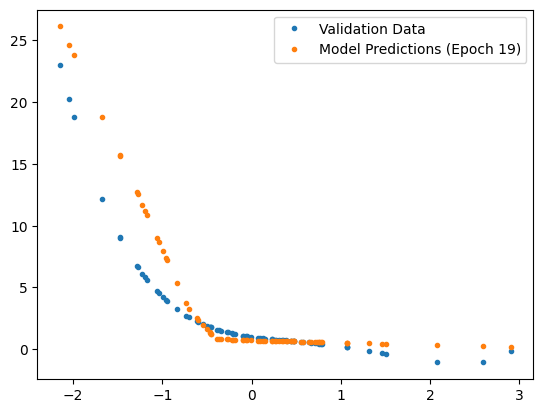

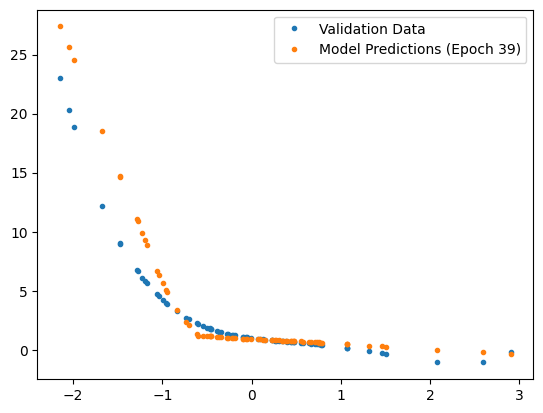

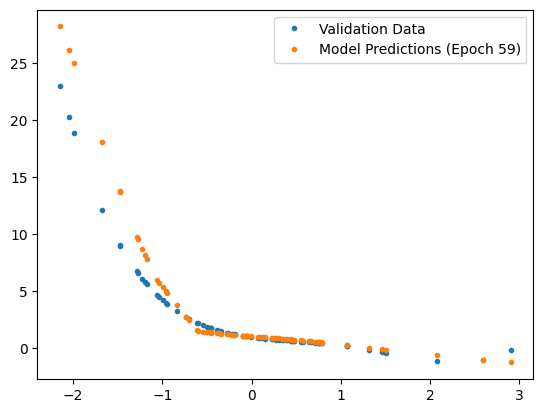

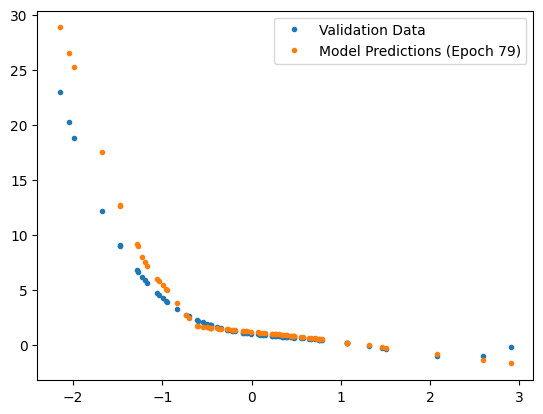

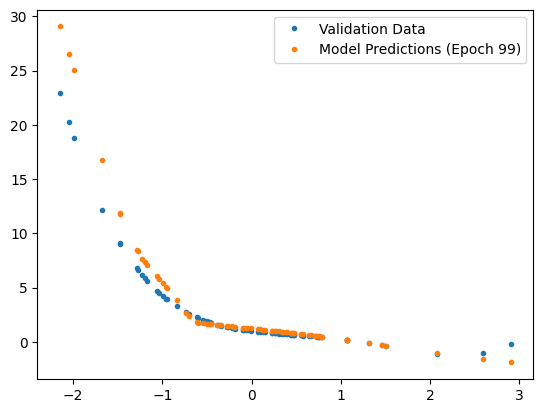

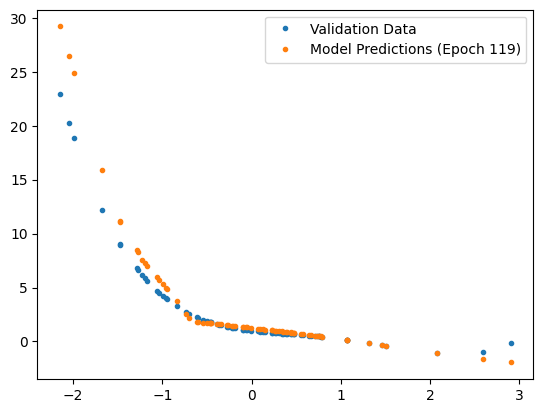

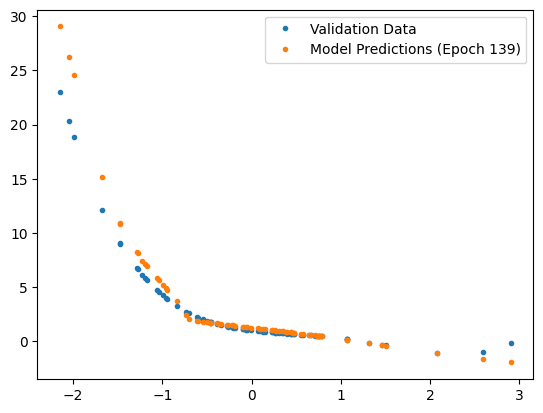

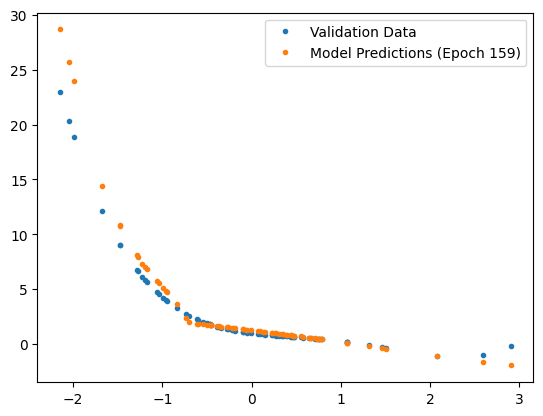

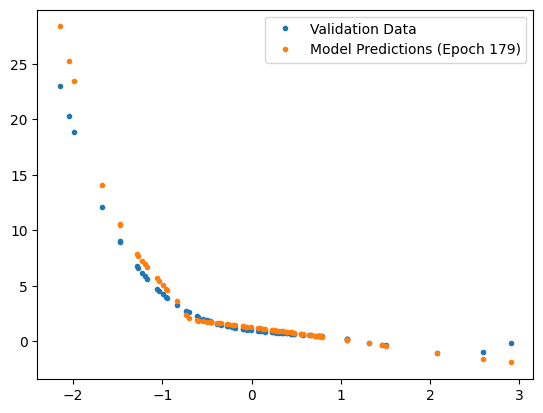

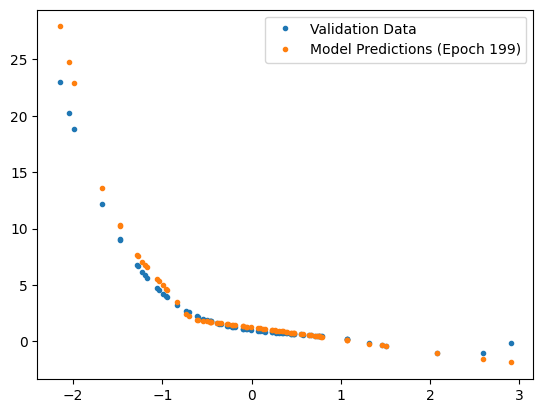

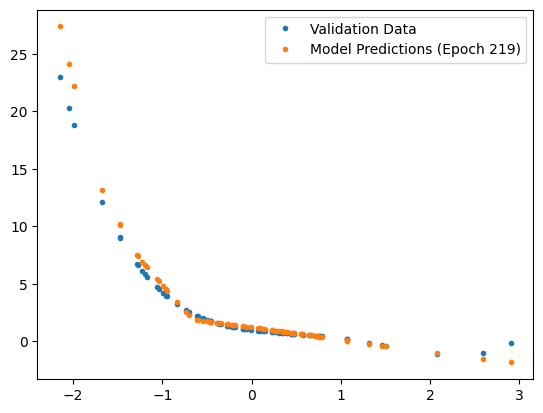

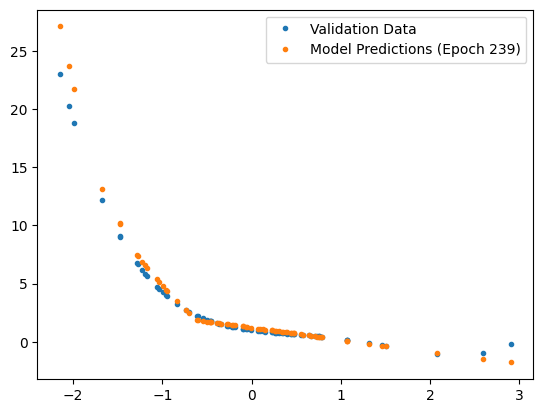

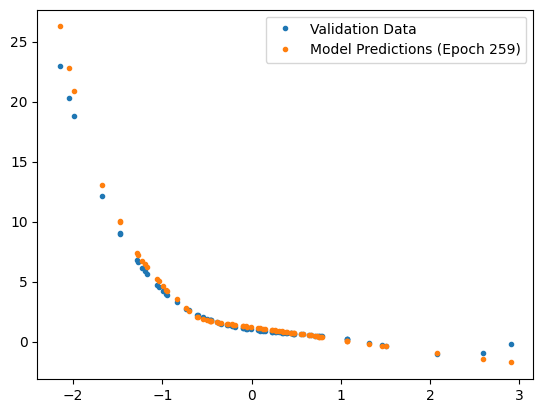

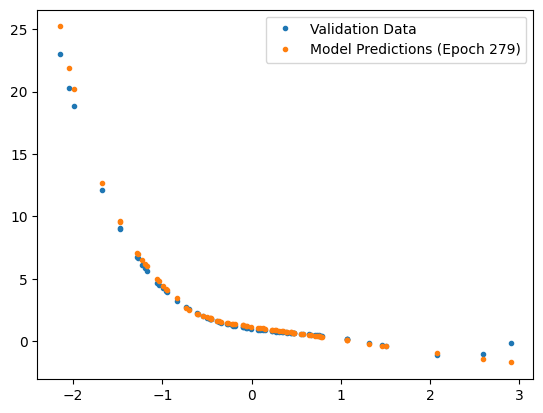

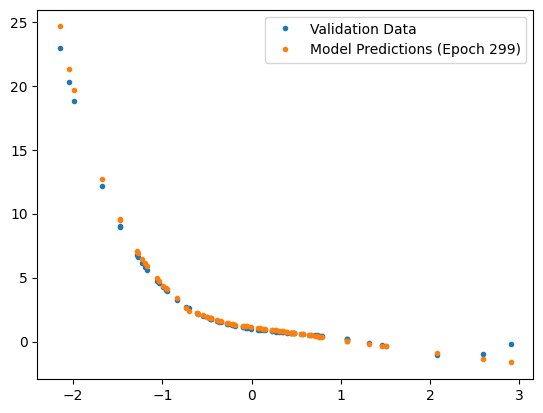

In [24]:
# parameters for steps
print_steps = 10
frame_steps = 20

frame_files = []

for epoch in range(num_epochs):
    outputs = model(X_train_py)
    loss = criterion(outputs,y_train_py)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch + 1) % print_steps == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    if (epoch + 1) % frame_steps == 0:
        frame_file_name = PlotCurrentModel(model,X_valid_py,y_valid_py,title="model0",label=f"Epoch {epoch}")
        frame_files.append(frame_file_name)

In [25]:
from PIL import Image

In [26]:

# Make an animation from the plots
print(frame_files)
imgs = [Image.open(file) for file in frame_files]
fps = 5
imgs[0].save(fp="anim.gif",format="GIF",append_images=imgs[1:],save_all=True,duration=int(1000/fps),loop=0)
for im_file in imgs:
    im_file.close()

['plots/model0_Epoch 19.png', 'plots/model0_Epoch 39.png', 'plots/model0_Epoch 59.png', 'plots/model0_Epoch 79.png', 'plots/model0_Epoch 99.png', 'plots/model0_Epoch 119.png', 'plots/model0_Epoch 139.png', 'plots/model0_Epoch 159.png', 'plots/model0_Epoch 179.png', 'plots/model0_Epoch 199.png', 'plots/model0_Epoch 219.png', 'plots/model0_Epoch 239.png', 'plots/model0_Epoch 259.png', 'plots/model0_Epoch 279.png', 'plots/model0_Epoch 299.png']


<img src="anim.gif" width="750" align="center">

In [27]:
with torch.no_grad():
    predictions = model(X_valid_py)

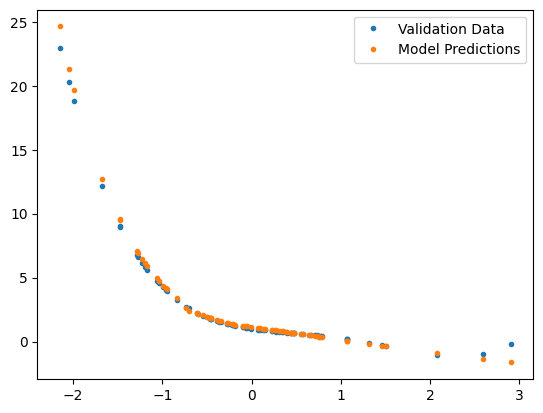

In [28]:
fig,ax = plt.subplots()
ax.plot(X_valid,y_valid,label="Validation Data",marker='.',linestyle='')
ax.plot(X_valid,predictions,label="Model Predictions",marker='.',linestyle='')

plt.legend()

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


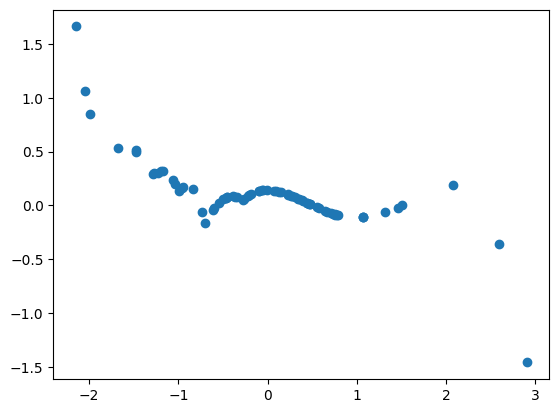

In [29]:
# Practice some Error analysis
print(type(predictions))
print(type(y_valid))
error = predictions[:,0] - y_valid
print(type(error))
fig,ax = plt.subplots()
ax.plot(X_valid,error,label="Error",marker='o',linestyle='')


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


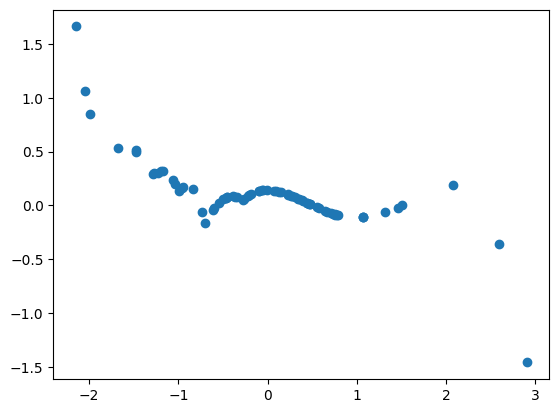

In [30]:
# Practice some Error analysis
print(type(predictions))
print(type(y_valid))
error = predictions[:,0] - y_valid
print(type(error))
fig,ax = plt.subplots()
ax.plot(X_valid,error,label="Error",marker='o',linestyle='')


In [31]:
abs_error = torch.abs(error)
print(abs_error.shape)
mean_absolute_error = torch.mean(abs_error,dim=0)
print(type(mean_absolute_error))
print(f"Mean Absolute Error = {mean_absolute_error}")

torch.Size([77])
<class 'torch.Tensor'>
Mean Absolute Error = 0.18252720189827107


In [32]:
print(model.parameters())
print(model)

<generator object Module.parameters at 0x7f43753ab7d0>
MyNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
